# **Final Assesment-1: Implementation of the Deutsch–Jozsa Algorithm**

---

      
Date: 13/11/2025

Name: M Harish Gautham

regno: 22MIS0421

---




###**Install & Imports**


In [ ]:
!pip install qiskit qiskit_aer --quiet
!pip install pylatexenc --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
%matplotlib inline
import time
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
import matplotlib.pyplot as plt
from IPython.display import Image, display

###**Helper: Safe Circuit Display**

> helper that draws circuits using 'mpl' if available, otherwise falls back to text output.



In [ ]:
def show_circuit(qc, filename="circuit.png"):
    try:
        fig = qc.draw(output='mpl')
        fig.savefig(filename, bbox_inches='tight')
        plt.close(fig)
        display(Image(filename))
    except Exception:
        print(qc.draw(output='text'))

### **Main Code:**


> **Define Oracles (3 input qubits + 1 ancilla)**





In [ ]:
def oracle_constant_0(qc, inputs, ancilla):
    # f(x) = 0 : do nothing
    pass

def oracle_constant_1(qc, inputs, ancilla):
    # f(x) = 1 : flip ancilla regardless of inputs
    qc.x(ancilla)

def oracle_balanced_parity(qc, inputs, ancilla):
    # f(x) = x0 XOR x1 XOR x2 (parity)
    for q in inputs:
        qc.cx(q, ancilla)

def oracle_balanced_custom(qc, inputs, ancilla):
    # balanced: flip ancilla when (x0 AND NOT x1) OR x2
    qc.x(inputs[1])
    qc.ccx(inputs[0], inputs[1], ancilla)
    qc.x(inputs[1])
    qc.cx(inputs[2], ancilla)



> **Build Deutsch–Jozsa circuit builder**



In [ ]:
def build_deutsch_jozsa(oracle_fn, name="oracle"):
    n = 3
    qreg = QuantumRegister(n + 1, "q")   # q0..q2 inputs, q3 ancilla
    creg = ClassicalRegister(n, "c")     # c0..c2 for measuring inputs
    qc = QuantumCircuit(qreg, creg)
    inputs = list(range(n))
    ancilla = n
    qc.x(ancilla)

    # Apply Hadamard to all qubits (inputs + ancilla)
    qc.h(range(n + 1))

    qc.barrier()
    # Oracle (in place)
    oracle_fn(qc, inputs, ancilla)

    qc.barrier()
    # Hadamard to input qubits only
    qc.h(inputs)

    qc.barrier()
    # Measure input qubits
    qc.measure(inputs, creg)

    qc.name = f"DJ_{name}"
    return qc

# Build circuits for later use
qc_const0 = build_deutsch_jozsa(oracle_constant_0, "const0")
qc_const1 = build_deutsch_jozsa(oracle_constant_1, "const1")
qc_bal_parity = build_deutsch_jozsa(oracle_balanced_parity, "balanced_parity")
qc_bal_custom = build_deutsch_jozsa(oracle_balanced_custom, "balanced_custom")


> **Visualize intermediate states (before and after oracle)**

Circuit: constant f(x)=0


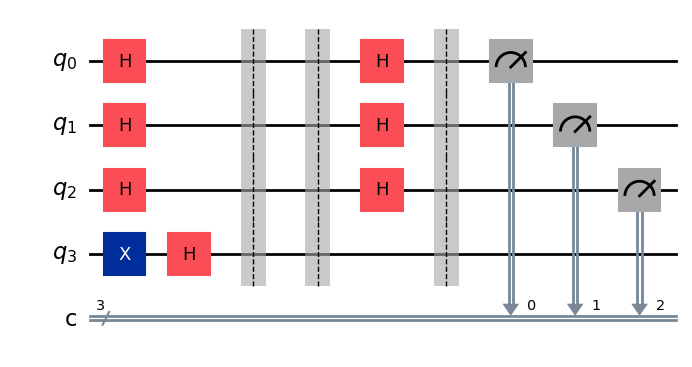


Circuit: constant f(x)=1


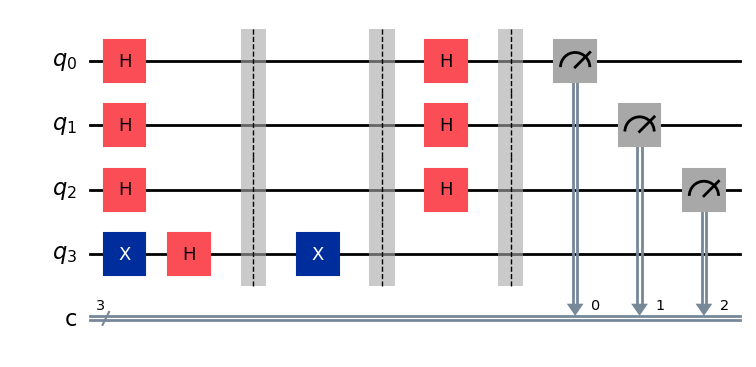


Circuit: balanced parity oracle


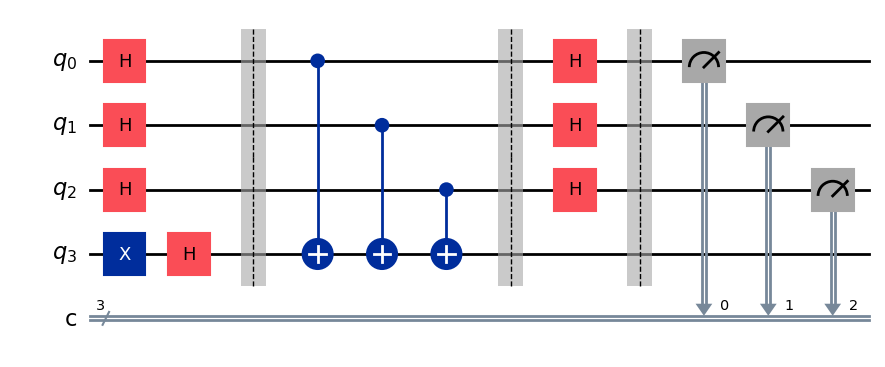


Circuit: balanced custom oracle


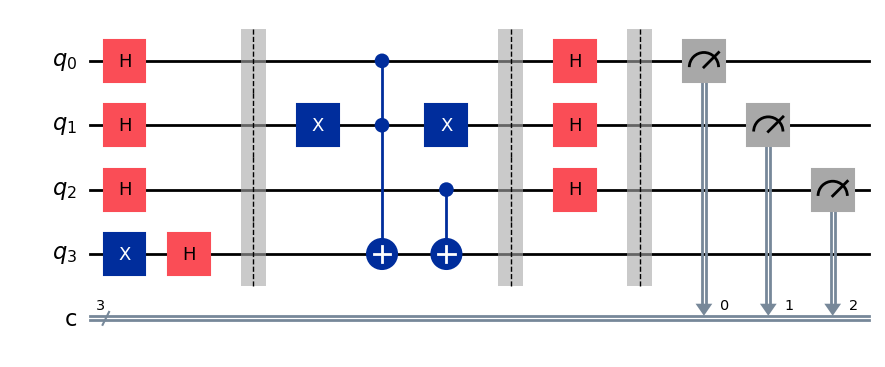

In [ ]:
print("Circuit: constant f(x)=0")
show_circuit(qc_const0)

print("\nCircuit: constant f(x)=1")
show_circuit(qc_const1)

print("\nCircuit: balanced parity oracle")
show_circuit(qc_bal_parity)

print("\nCircuit: balanced custom oracle")
show_circuit(qc_bal_custom)

>**Intermediate states (Bloch & Statevector)**

In [ ]:
def build_intermediate(oracle_fn):
    n = 3
    qc_pre = QuantumCircuit(n+1)
    qc_pre.x(n)
    qc_pre.h(range(n+1))

    qc_post = qc_pre.copy()
    qc_post.barrier()
    oracle_fn(qc_post, list(range(n)), n)
    return qc_pre, qc_post

def visualize_state(qc_state, label):
    try:
        sv = Statevector.from_instruction(qc_state)
    except Exception as e:
        print("Statevector error:", e)
        return

    # state city
    try:
        fig_city = plot_state_city(sv)
        fig_city.savefig(f"{label}_city.png", bbox_inches='tight')
        plt.close(fig_city)
        display(Image(f"{label}_city.png"))
    except Exception:
        pass

    # bloch multivector
    try:
        fig_bloch = plot_bloch_multivector(sv)
        fig_bloch.savefig(f"{label}_bloch.png", bbox_inches='tight')
        plt.close(fig_bloch)
        display(Image(f"{label}_bloch.png"))
    except Exception:
        pass

State after initial H (before oracle) - balanced parity:


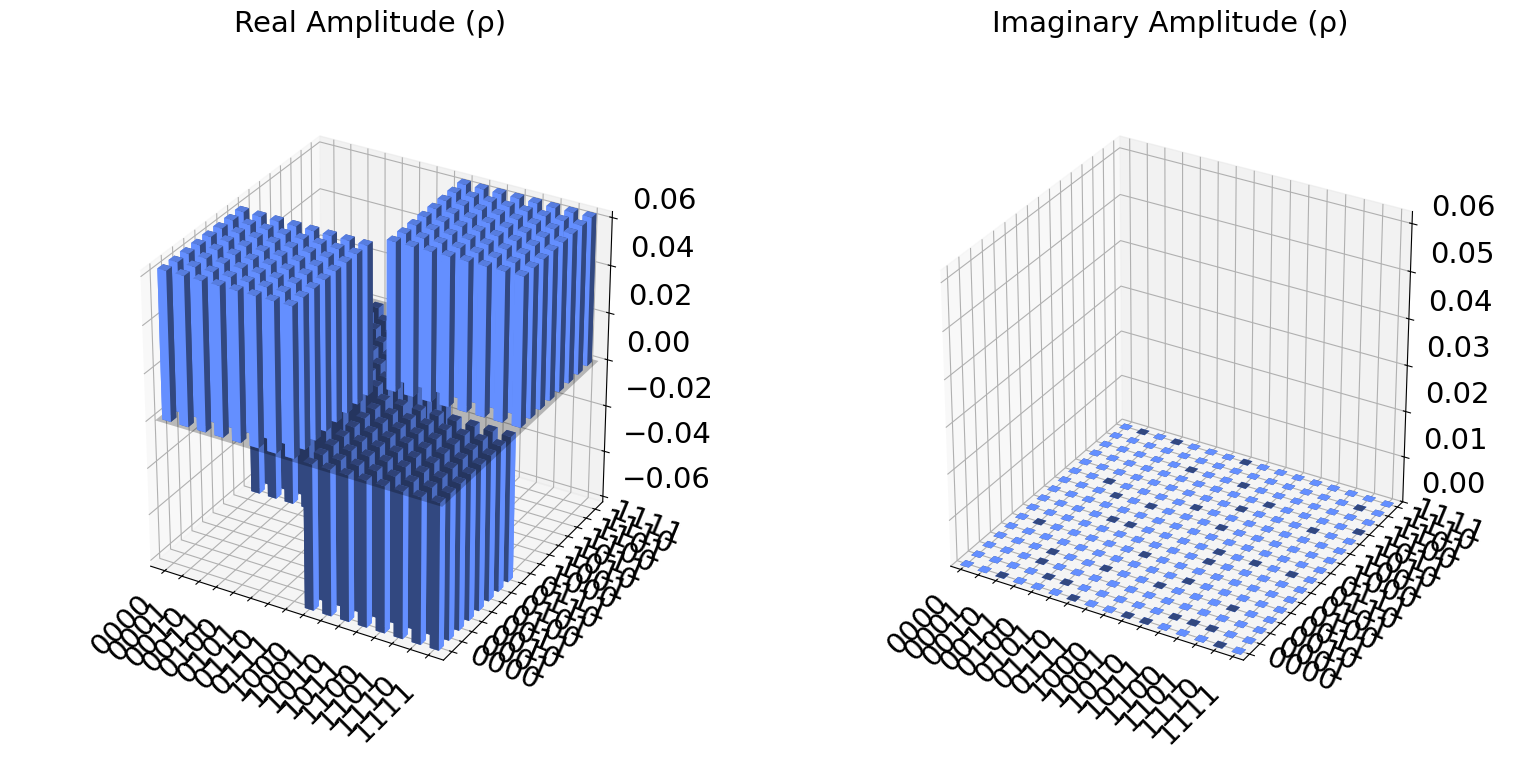

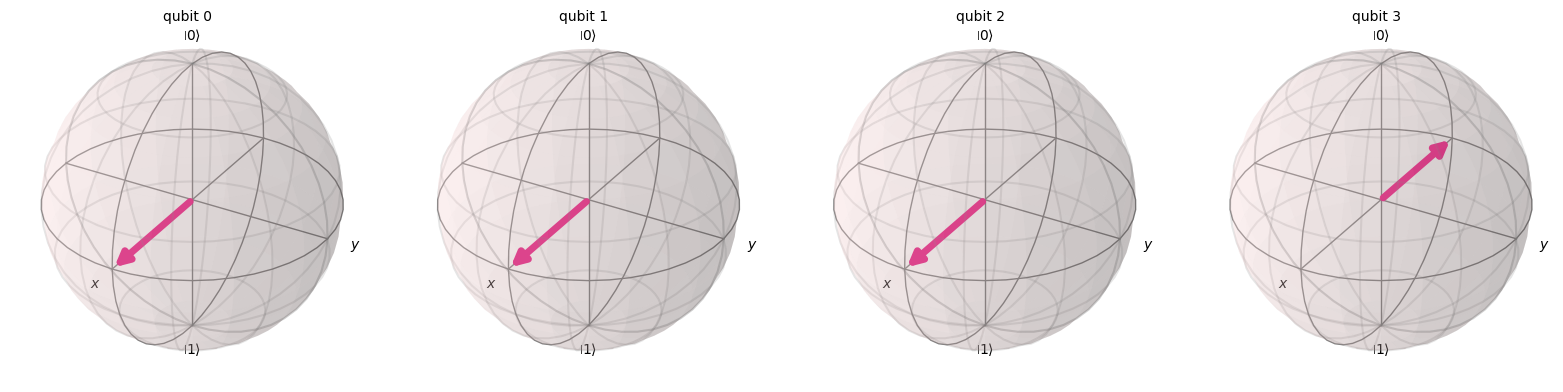

State after oracle (before final H) - balanced parity:


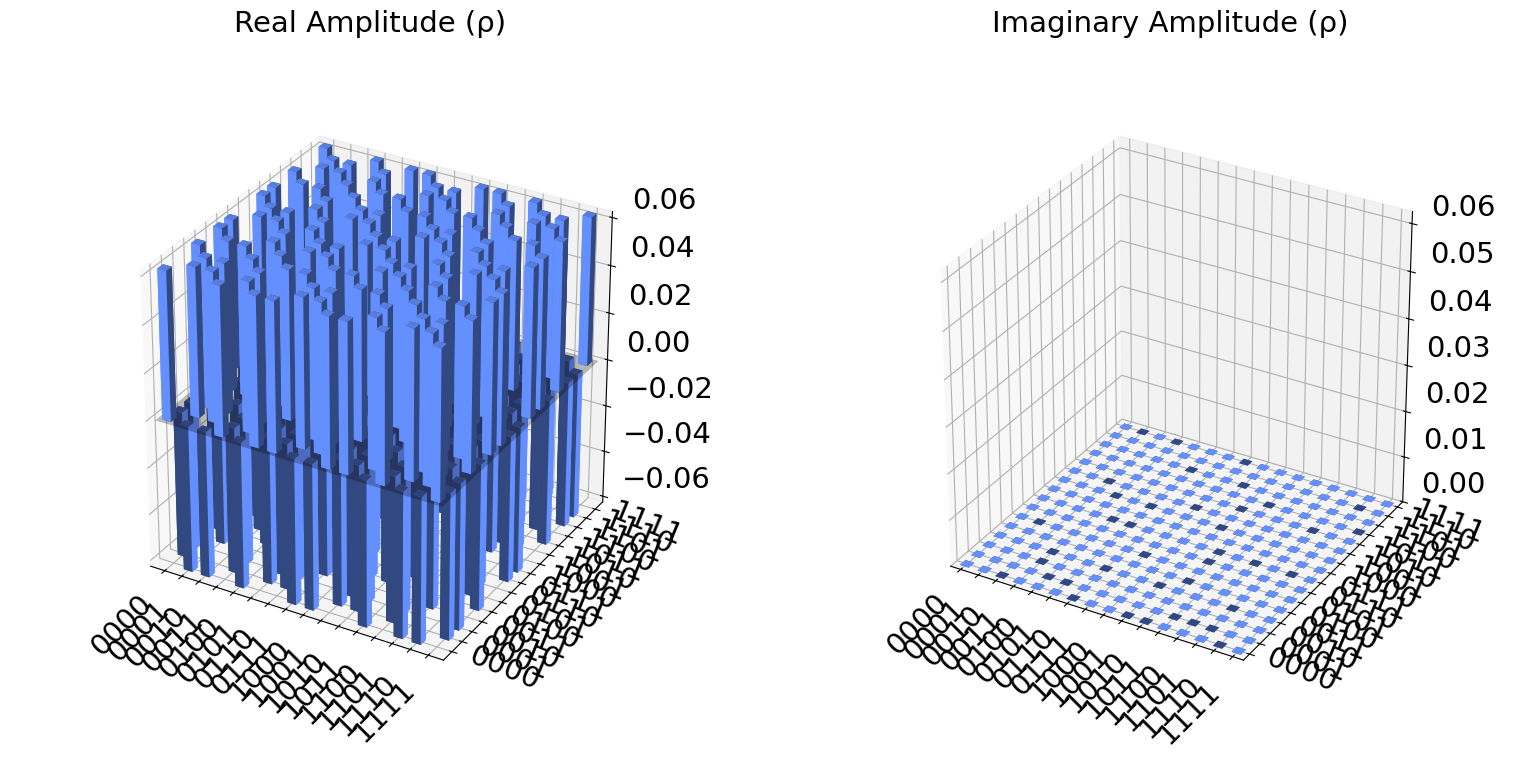

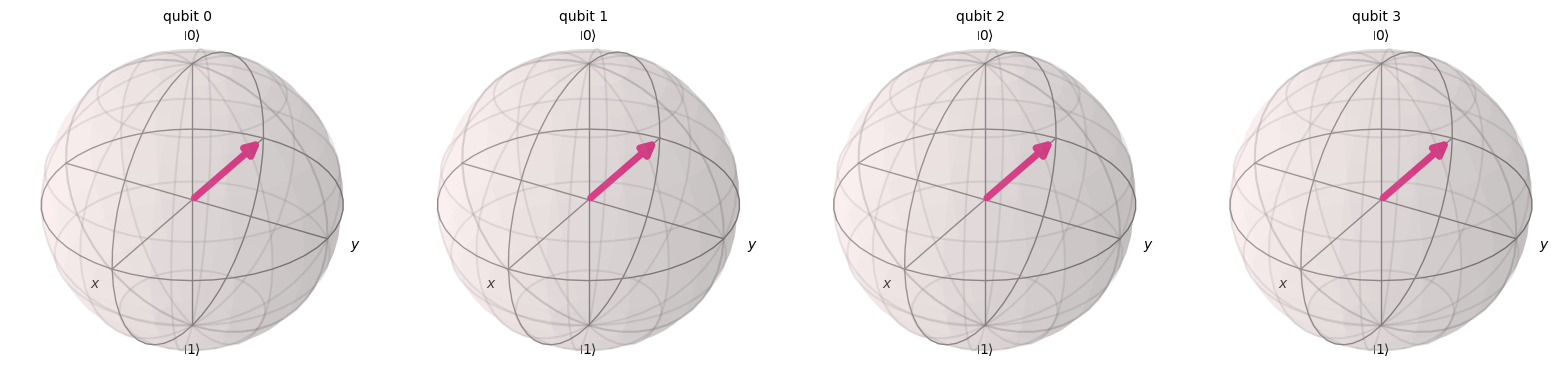

In [ ]:
# Balanced parity
pre, post = build_intermediate(oracle_balanced_parity)
print("State after initial H (before oracle) - balanced parity:")
visualize_state(pre, "balanced_pre")
print("State after oracle (before final H) - balanced parity:")
visualize_state(post, "balanced_post")

State after initial H (before oracle) - constant f=1:


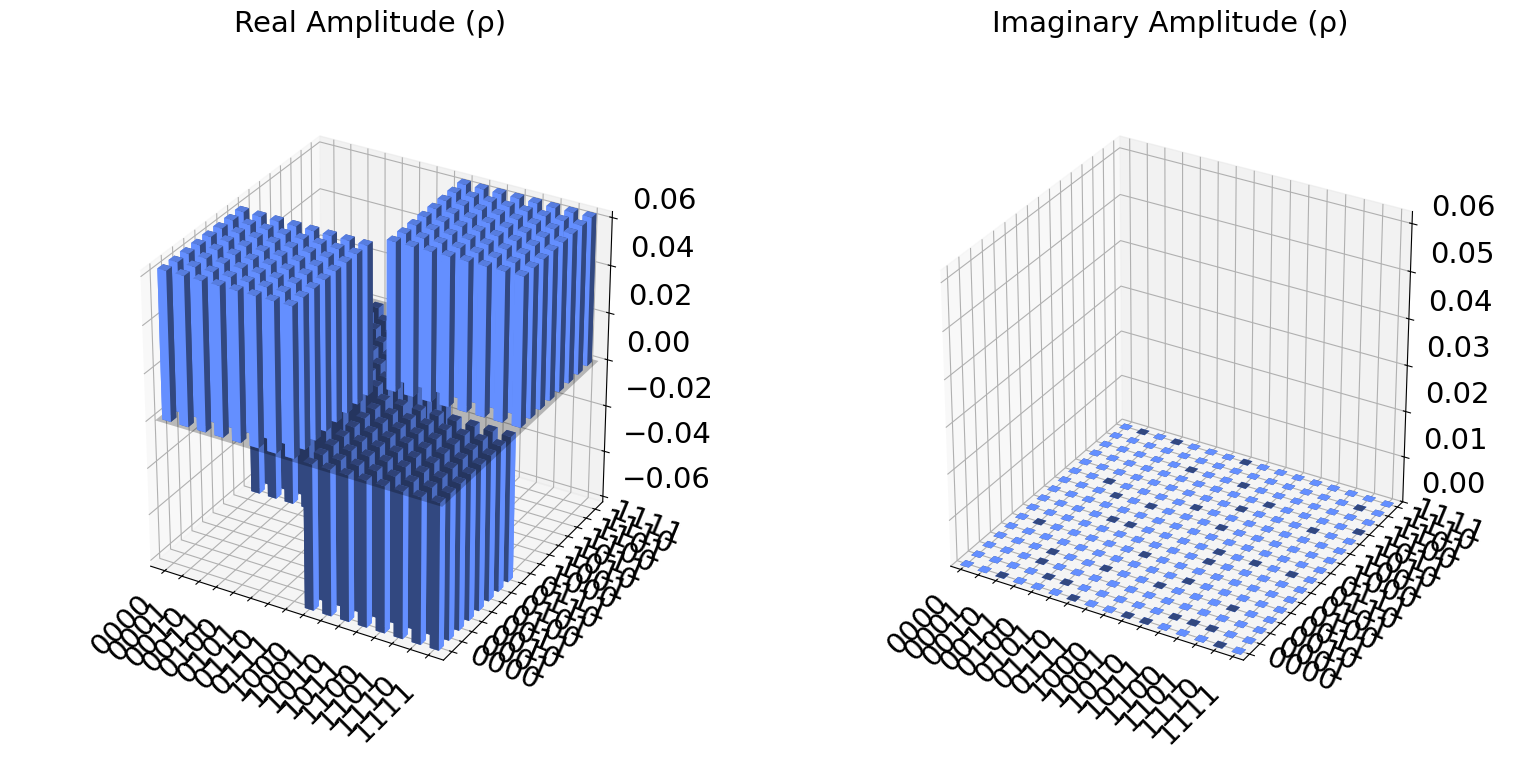

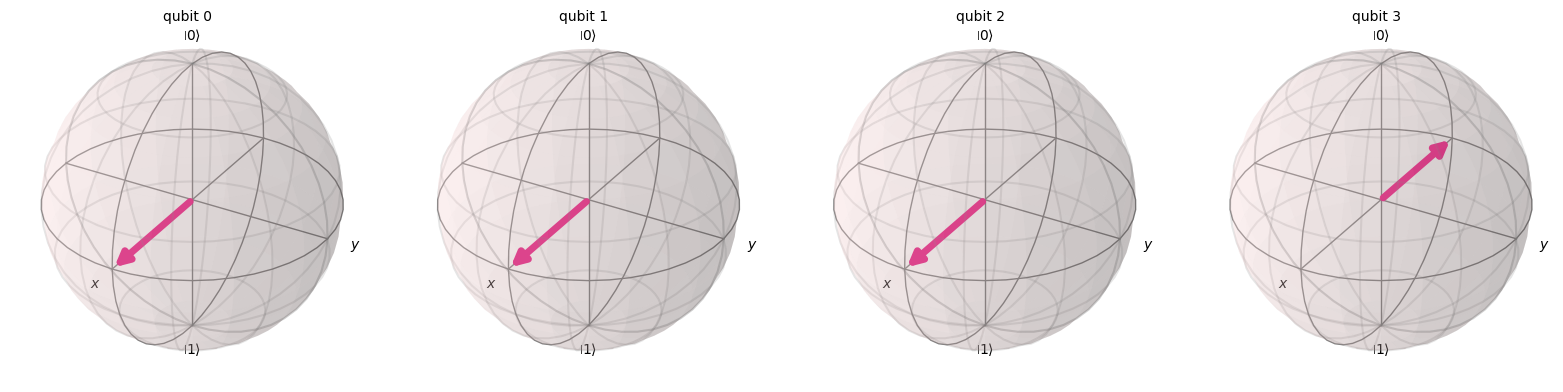

State after oracle (before final H) - constant f=1:


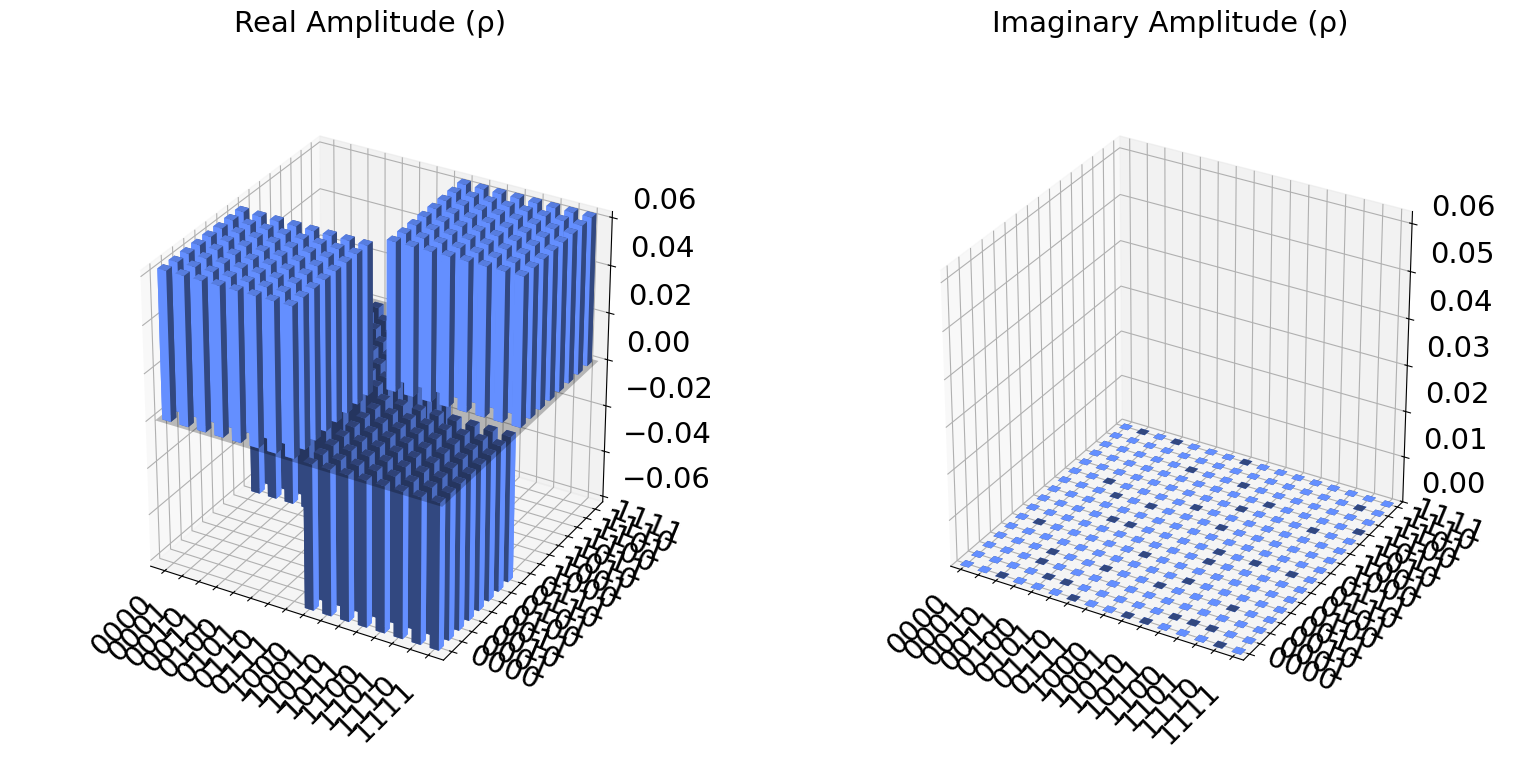

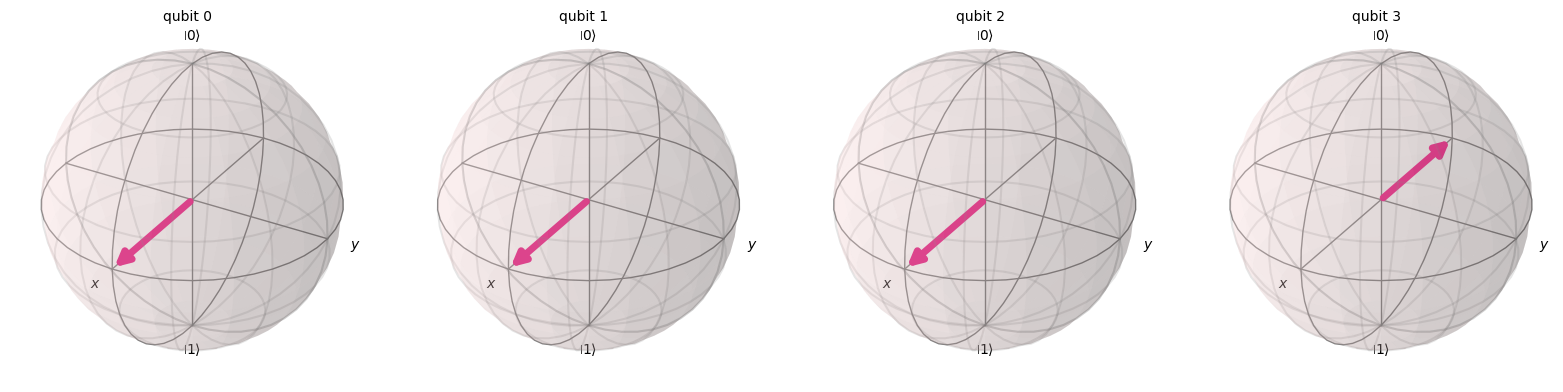

In [ ]:
# Constant-1
pre1, post1 = build_intermediate(oracle_constant_1)
print("State after initial H (before oracle) - constant f=1:")
visualize_state(pre1, "const1_pre")
print("State after oracle (before final H) - constant f=1:")
visualize_state(post1, "const1_post")

>**Simulate circuits and plot histograms (1024 shots)**

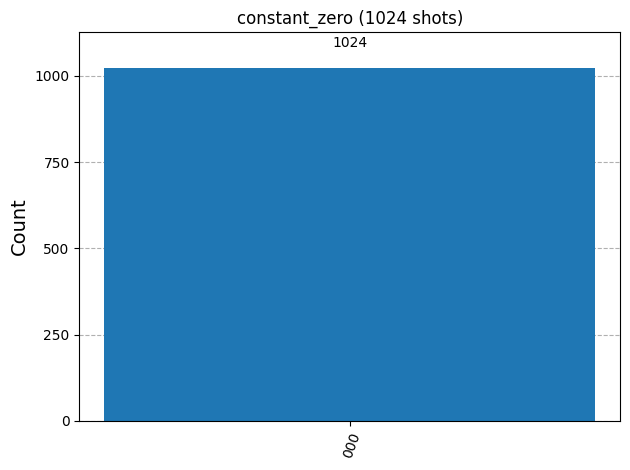

constant_zero counts: {'000': 1024}


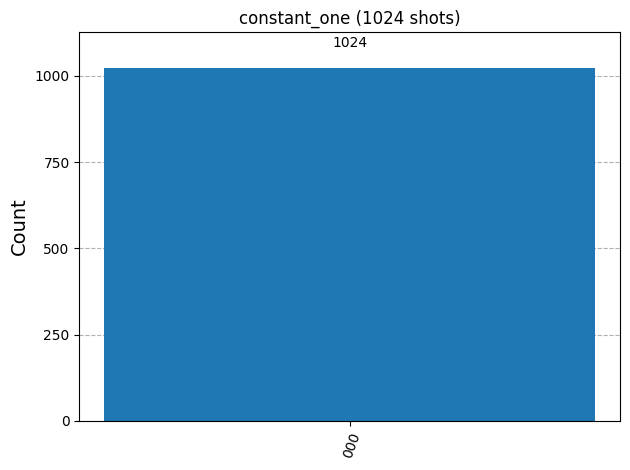

constant_one counts: {'000': 1024}


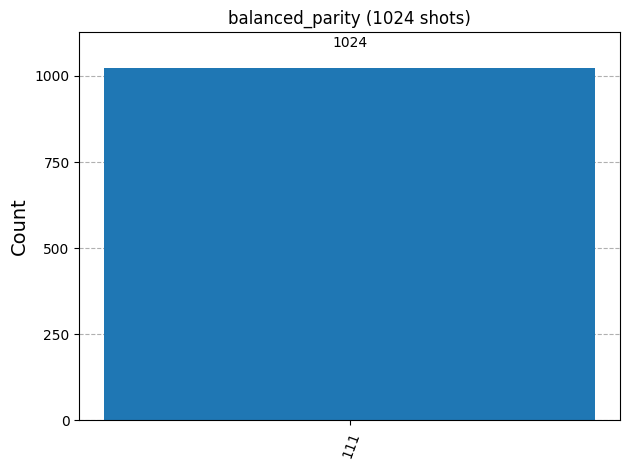

balanced_parity counts: {'111': 1024}


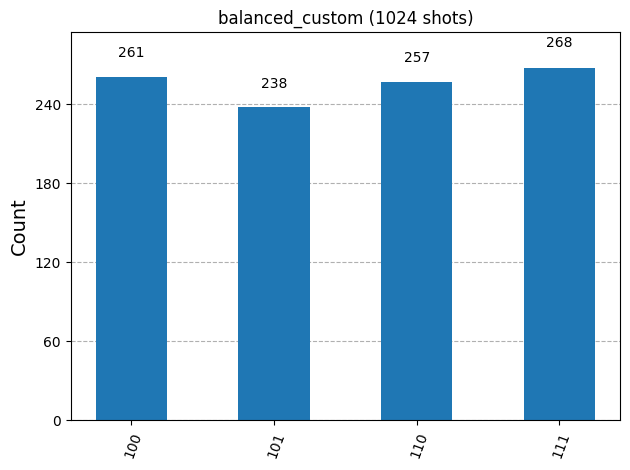

balanced_custom counts: {'101': 238, '110': 257, '111': 268, '100': 261}


In [ ]:
sim = AerSimulator()

def run_and_plot(qc, label):
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=1024)
    res = job.result()
    counts = res.get_counts()
    fig = plot_histogram(counts, title=f"{label} (1024 shots)")
    fig.savefig(f"{label}_hist.png", bbox_inches='tight')
    plt.close(fig)
    display(Image(f"{label}_hist.png"))
    print(f"{label} counts:", counts)

run_and_plot(qc_const0, "constant_zero")
run_and_plot(qc_const1, "constant_one")
run_and_plot(qc_bal_parity, "balanced_parity")
run_and_plot(qc_bal_custom, "balanced_custom")


>**Transpile benchmarking across optimization levels**

In [ ]:
def benchmark(qc, sim_backend, shots=1024):
    records = []
    for opt in [0,1,2,3]:
        t0 = time.perf_counter()
        tqc = transpile(qc, sim_backend, optimization_level=opt)
        t_tx = time.perf_counter() - t0

        depth = tqc.depth()
        ops = tqc.count_ops()
        size = tqc.size()

        t1 = time.perf_counter()
        _ = sim_backend.run(tqc, shots=shots).result()
        t_run = time.perf_counter() - t1

        records.append({
            "opt": opt,
            "depth": depth,
            "size": size,
            "ops": dict(ops),
            "transpile_s": t_tx,
            "run_s": t_run
        })
    return records

cases = {
    "const0": qc_const0,
    "const1": qc_const1,
    "balanced_parity": qc_bal_parity,
    "balanced_custom": qc_bal_custom
}

all_bench = {}
for name, qc in cases.items():
    print(f"\nBenchmarking {name} ...")
    all_bench[name] = benchmark(qc, sim, shots=1024)
    for r in all_bench[name]:
        print(f"opt={r['opt']}: depth={r['depth']}, size={r['size']}, ops={r['ops']}, transpile_s={r['transpile_s']:.4f}, run_s={r['run_s']:.4f}")



Benchmarking const0 ...
opt=0: depth=4, size=11, ops={'h': 7, 'barrier': 3, 'measure': 3, 'x': 1}, transpile_s=0.1416, run_s=0.0035
opt=1: depth=3, size=10, ops={'h': 6, 'barrier': 3, 'measure': 3, 'u2': 1}, transpile_s=0.1459, run_s=0.0034
opt=2: depth=3, size=10, ops={'h': 6, 'barrier': 3, 'measure': 3, 'u2': 1}, transpile_s=0.1595, run_s=0.0036
opt=3: depth=3, size=10, ops={'h': 6, 'barrier': 3, 'measure': 3, 'u2': 1}, transpile_s=0.1533, run_s=0.0036

Benchmarking const1 ...
opt=0: depth=5, size=12, ops={'h': 7, 'barrier': 3, 'measure': 3, 'x': 2}, transpile_s=0.1470, run_s=0.0034
opt=1: depth=4, size=11, ops={'h': 6, 'barrier': 3, 'measure': 3, 'u2': 1, 'x': 1}, transpile_s=0.1464, run_s=0.0065
opt=2: depth=4, size=11, ops={'h': 6, 'barrier': 3, 'measure': 3, 'u2': 1, 'x': 1}, transpile_s=0.1622, run_s=0.0034
opt=3: depth=4, size=11, ops={'h': 6, 'barrier': 3, 'measure': 3, 'u2': 1, 'x': 1}, transpile_s=0.1765, run_s=0.0034

Benchmarking balanced_parity ...
opt=0: depth=7, size=1

# **Short Analysis:**

### Theoretical expectation for Deutsch–Jozsa (3 input qubits):
- Constant f(x): the measured input register should be '000' for all shots.
- Balanced f(x): the measured input register should NOT be '000' (some nonzero output).

### Observed histograms:
- Check constant_zero and constant_one histograms: they should show '000' as the dominant (ideally only) outcome.
- Check balanced_parity and balanced_custom histograms: they show outcomes different from '000'.

###Transpilation results summary:
- Optimization levels (0..3) show trade-offs: higher opt may reduce depth/size and gate counts but can increase transpile time.
- Balanced oracles typically require more multi-qubit gates (cx/ccx) -> deeper circuits and larger gate counts than constant oracles.


###Conclusion✨:
The simulation and the transpilation metrics confirm the Deutsch–Jozsa algorithm behaviour and illustrate optimization trade-offs in Qiskit transpiler.


---

